In [1]:
import sys
sys.path.append('../')

# Environment Variables
environ = 'local'

In [2]:
from scipy.signal import savgol_filter

import numpy as np

def savitzky_golay_filter(data, window_size=5, polynomial_order=3):
    """Applies a Savitzky-Golay filter to the data."""
    return savgol_filter(data, window_size, polynomial_order)

def differentiate(data, time):
    """Differentiates data with respect to time."""
    return np.gradient(data, time)

def add_steering_velocity(df):
    """Adds a new feature to the dataframe: steering velocity."""
    
    df = df.copy()
    
   #  assert (df['t'].diff() > 0).all(), "Timestamps are not strictly increasing!"

    # df.loc[:, 'steeringVelocity'] = differentiate(df['steeringAngleDeg'], df['t'])
    df['steeringVelocity'] = df['steeringAngleDeg'].diff() / (df['t'].diff() + 1e-8)

    # TODO: Add/explore preprocessing for steering velocity
    # Replace inf/-inf with the maximum/minimum finite values
    # df.replace([np.inf, -np.inf], np.nan, inplace=True)
    max_finite = df['steeringVelocity'][np.isfinite(df['steeringVelocity'])].max()
    min_finite = df['steeringVelocity'][np.isfinite(df['steeringVelocity'])].min()
    df['steeringVelocity'] = np.clip(df['steeringVelocity'], min_finite, max_finite)

    # df['steeringVelocity'] = df['steeringVelocity'].rolling(window=5, min_periods=1).mean()
    df.fillna(0, inplace=True)

    # Apply filter to remove noise
    df['steeringVelocity'] = savitzky_golay_filter(df['steeringVelocity'], 5, 2)
    # df['steeringVelocity'] = moving_average(df['steeringVelocity'], 1)

    return df

def add_steering_acceleration(df):
    """Adds a new feature to the dataframe: steering acceleration."""

    df = df.copy()

    # assert (df['t'].diff() > 0).all(), "Timestamps are not strictly increasing!"

    # df.loc[:, 'steeringAcceleration'] = differentiate(df['steeringVelocity'], df['t'])
    df['steeringAcceleration'] = df['steeringVelocity'].diff() / (df['t'].diff() + 1e-8)

    # df.replace([np.inf, -np.inf], np.nan, inplace=True)
    max_finite = df['steeringAcceleration'][np.isfinite(df['steeringAcceleration'])].max()
    min_finite = df['steeringVelocity'][np.isfinite(df['steeringAcceleration'])].min()
    df['steeringAcceleration'] = np.clip(df['steeringAcceleration'], min_finite, max_finite)

    # df['steeringAcceleration'] = df['steeringAcceleration'].rolling(window=5, min_periods=1).mean()
    df.fillna(0, inplace=True)

    # Apply filter to remove noise
    df['steeringAcceleration'] = savitzky_golay_filter(df['steeringAcceleration'], 5, 2)
    # df['steeringVelocity'] = moving_average(df['steeringVelocity'], 1)

    return df


In [4]:
import logging

from data.csc_data import CSCDataset
from data.df_preprocessing import CompositeDP, FeatureAdderDP, FeatureRemoverDP

DATASET_NAME = 'HONDA_CIVIC_BOSCH_2019'
IS_PREDICTION = False


# TODO: These will be part of the training data pipeline in the actual code (not a notebook)
# When deploying the model, we will have access to velocity and acceleration (in CARLA)

# Not using MinMaxScalerDP for now (XGBoost is not sensitive to feature scaling)
train_preprocessor = CompositeDP([
    FeatureAdderDP([
        add_steering_velocity,
        add_steering_acceleration
    ]),
    FeatureRemoverDP(['t'])
])

label_preprocessor = None


dataset = CSCDataset(DATASET_NAME, 
                     ['steeringAngleDeg', 't'],
                     download=True,
                     train_preprocessor=train_preprocessor,
                     label_preprocessor=label_preprocessor,
                     is_prediction=IS_PREDICTION,
                     logging_level=logging.INFO)
total_dataset_size, num_csv = dataset.get_csv_metadata()

print(f"Total file size of dataset: {round(total_dataset_size, 3)} MB")
print(f"Number of CSV files in dataset: {num_csv}")

print(f"Number of samples in dataset: {len(dataset)}")

Total file size of dataset: 1843.187 MB
Number of CSV files in dataset: 14000
Number of samples in dataset: 14000


In [5]:
from torch.utils.data import DataLoader

# Load all data at once
train_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

# Extract features and labels
features_list, targets_list = [], []

for batch_idx, (X, y) in enumerate(train_loader):
    # Convert PyTorch tensors to NumPy
    features_list.append(X.numpy())  
    targets_list.append(y.numpy())


# Convert to NumPy arrays
# Shape: (num_samples, num_features)
X_np = np.vstack(features_list)

# Shape: (num_samples,)
y_np = np.hstack(targets_list)   

# Check data shape
print("Features shape:", X_np.shape)
print("Targets shape:", y_np.shape)



Features shape: (14000, 611, 3)
Targets shape: (14000, 611)


In [6]:

# Shape 3D (6500, 611, 3) -> (6500 * 611, 3)
X_np = X_np.reshape(-1, X_np.shape[-1])
# Shape 3D (6500, 611, 1) -> (6500 * 611, 1)
y_np = y_np.reshape(-1, 1)

print(X_np.shape)
print(y_np.shape)

steering_acceleration = X_np[:, -1]
torque = y_np

print(steering_acceleration.shape)
print(torque.shape)

(8554000, 3)
(8554000, 1)
(8554000,)
(8554000, 1)


In [ ]:
from sklearn.linear_model import LinearRegression

steering_acceleration = steering_acceleration.reshape(-1, 1)

reg = LinearRegression().fit(steering_acceleration, torque)
J_estimated = reg.coef_[0]  # J is the slope

print(f"Estimated J: {J_estimated}")

Estimated J: [-4.44777875e-12]


Estimated moments of inertia (J's)

-AUDI_Q3_2ND_GEN dataset: 6.44902232e-11

-LEXUS_RX_2020: -6.79980175e-12

-HONDA_CIVIC_BOSCH_2019 -4.44777875e-12

Predicting CSV file ID: 1709
Skipped 1709 files
(8554000, 3)
(8554000, 1)
(611, 3)
(611, 1)
Prediction time: 0.040993452072143555 seconds
(8554000, 1)


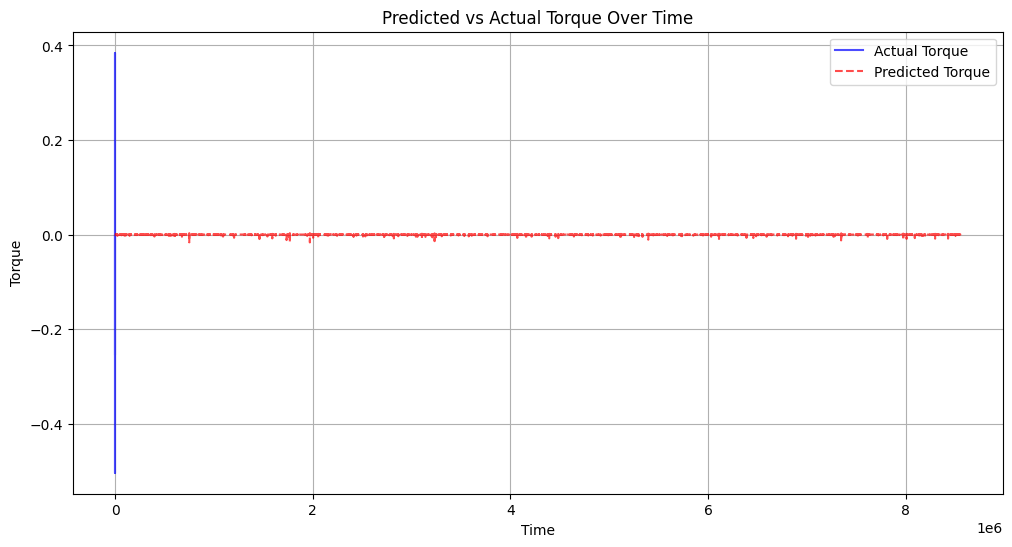

In [12]:
# Plot estimated torque from T = J * alpha

import time
import random
import matplotlib.pyplot as plt

DATASET_NAME = 'LEXUS_RX_2020'
IS_PREDICTION = True


# TODO: These will be part of the training data pipeline in the actual code (not a notebook)
# When deploying the model, we will have access to velocity and acceleration (in CARLA)

# Not using MinMaxScalerDP for now (XGBoost is not sensitive to feature scaling)
train_preprocessor = CompositeDP([
    FeatureAdderDP([
        add_steering_velocity,
        add_steering_acceleration
    ]),
    FeatureRemoverDP(['t'])
])

label_preprocessor = None


test_dataset = CSCDataset(DATASET_NAME, 
                     ['steeringAngleDeg', 't'],
                     download=True,
                     train_preprocessor=train_preprocessor,
                     label_preprocessor=label_preprocessor,
                     is_prediction=IS_PREDICTION,
                     logging_level=logging.INFO)


# Load one csv file at a time
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Extract features and labels
features_list, targets_list = [], []

skipped = 0

# Randomly select csv file to predict
csv_id = random.randint(0, len(test_dataset) - 1)
print(f"Predicting CSV file ID: {csv_id}")


X = None
y = None


for batch_idx, (X, y) in enumerate(test_loader):

    if not batch_idx == csv_id:
        skipped += 1
        continue

    print(f"Skipped {skipped} files")

    # Convert PyTorch tensors to NumPy
    X = X.numpy()  
    y = y.numpy()
    break


num_features = X.shape[2]



# Shape 3D (6500, 611, 3) -> (6500 * 611, 3)
X_np = X_np.reshape(-1, X_np.shape[-1])
# Shape 3D (6500, 611, 1) -> (6500 * 611, 1)
y_np = y_np.reshape(-1, 1)

print(X_np.shape)
print(y_np.shape)

steering_acceleration = X_np[:, -1]
steering_acceleration = steering_acceleration.reshape(-1, 1)

# Plotting
# Convert to NumPy arrays
# Shape: (num_samples, num_features)
X = X.reshape(-1, num_features)
actual_torque = y.reshape(-1, 1)

print(X.shape)
print(actual_torque.shape)

time_start = time.time()
predicted_torque = J_estimated * steering_acceleration
time_end = time.time()

print(f"Prediction time: {time_end - time_start} seconds")

print(predicted_torque.shape)


# Plot predicted vs actual torque
plt.figure(figsize=(12, 6))
plt.plot(actual_torque, label="Actual Torque", linestyle="-", color="blue", alpha=0.7)
plt.plot(predicted_torque, label="Predicted Torque", linestyle="--", color="red", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Torque")
plt.title("Predicted vs Actual Torque Over Time")
plt.legend()
plt.grid(True)
plt.show()
